In [1]:
#! /usr/bin/env python
import os
import argparse
import datetime
import re
import numpy as np
import random
import pandas as pd

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

In [3]:
from torchtext import data
from visdom import Visdom
viz = Visdom()
random.seed(1111)
torch.manual_seed(1111)

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

In [5]:
from data import tokenizer, data_split, preprocess_dataset, create_batches
from data import SemEval10_task8

In [6]:
def l2_loss(parameters):
    norm = 0
    for param in parameters:
        norm += torch.sum((param**2))
    return norm

In [7]:
class Baseline_Model(nn.Module):
    def __init__(self, word_vocab, label_vocab, word_emb_dim, pos_emb_dim, hidden_dim, output_dim, MAX_POS = 15, use_gpu = True):
        super(Baseline_Model, self).__init__()
        
        # Set hyper parameters
        self.word_emb_dim = word_emb_dim
        self.pos_emb_dim = pos_emb_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_dim = word_emb_dim
        
        self.MAX_POS = MAX_POS
        
        
        # Set options and other parameters
        self.use_gpu = use_gpu
        self.word_vocab = word_vocab
        self.label_vocab = label_vocab
        #self.pos_vocab = pos_vocab
        
        
        # Free parameters for the model
        # Initialize embeddings (Word and Position embeddings) 
        self.word_emb = nn.Embedding(len(self.word_vocab), self.word_emb_dim).cuda()
        
        self.pos1_emb = nn.Embedding(self.MAX_POS*2+1, self.pos_emb_dim).cuda()
        self.pos1_emb.weight.data.uniform_(-0.0, 0.0)
        self.pos2_emb = nn.Embedding(self.MAX_POS*2+1, self.pos_emb_dim).cuda()
        self.pos2_emb.weight.data.uniform_(-0.0, 0.0)
        
        # Initialize LSTM parameters ()
        self.rnn = nn.GRU(self.input_dim, hidden_dim, bidirectional=True, batch_first = True).cuda()
        
        
        # Initialize Attention parameters ()
        self.attention_hidden = nn.Linear(hidden_dim * 2, hidden_dim,bias=False).cuda()
        self.attention = nn.Linear(hidden_dim, 1, bias=False).cuda()
        
        # Initialize Classifier parameters ()
        #self.classifier_hidden = nn.Linear(hidden_dim * 2, hidden_dim).cuda()
        self.classifier = nn.Linear(hidden_dim * 2, output_dim).cuda()
        
        
        self.word_emb.weight.data.copy_(word_vocab.vectors)
        
        
        # Other options
        self.TSNE_model = None
    def prepare_inout(self, X, y=None):
        sents, pos1, pos2 = list(zip(*X))
        #sents = list(zip(*X))
        #pos1 = datas['position_indices_1']
        #pos2 = datas['position_indices_2']
        
        labels = y
        
        words = [ [ self.word_vocab.stoi[word] for word in sent] for sent in sents]
        #print(words)
        words_var = Variable(torch.LongTensor(words).cuda())
        #print(words_var)
        word_embeddings = self.word_emb(words_var)
        #print(word_embedings)
        
        pos1 = np.array(pos1).astype('int')
        #print(pos1)
        pos1_var = Variable(torch.LongTensor(pos1).cuda())
        pos1_embeddings = self.pos1_emb(pos1_var)
        #print(pos1_var)
        #print(pos1_embeddings)

        pos2 = np.array(pos2).astype('int')
        #print(pos2)
        pos2_var = Variable(torch.LongTensor(pos2).cuda())
        pos2_embeddings = self.pos2_emb(pos2_var)
        
        
        inputs = {'word_embeddings': word_embeddings,
                  'pos1_embeddings': pos1_embeddings,
                  'pos2_embeddings': pos2_embeddings}
        #inputs = torch.cat((word_embeddings, pos1_embeddings, pos2_embeddings),-1)
        #print(inputs)
        
        """print(labels)
        if labels:
            labels = [ self.label_vocab.stoi[label] - 1 for label in labels]
            labels_var = Variable(torch.LongTensor(labels).cuda())
            outputs = labels_var
        else:
            outputs = None
        """
        labels = [ self.label_vocab.stoi[label] - 1 for label in labels]
        labels_var = Variable(torch.LongTensor(labels).cuda())
        outputs = labels_var
        return inputs, outputs
        
        
        
        
    def forward(self, inputs, is_train = True):
        word_embeddings = inputs['word_embeddings']
        pos1_embeddings = inputs['pos1_embeddings']
        pos2_embeddings = inputs['pos2_embeddings']
        
        # LSTM layer
        #X = torch.cat((word_embeddings, pos1_embeddings, pos2_embeddings),-1)
        X = word_embeddings
        X = F.dropout(X, p=0.5, training=is_train)
        hiddens, for_output = self.rnn(X)
        
        hiddens = hiddens
        #rev_hiddens, rev_output = self.rev_lstm(X)
        
        # Self Attentive layer
        #att_input = torch.cat((hiddens, pos1_embeddings, pos2_embeddings),-1)
        att_input = hiddens
        att_input = F.dropout(att_input, p=0.5, training=is_train)
        att_hidden = F.tanh(self.attention_hidden(att_input))
        att_hidden = F.dropout(att_hidden, p=0.5, training=is_train)
        att_scores = self.attention(att_hidden)
        
        attention_distrib = F.softmax(att_scores, dim = 1)
        hiddens = F.dropout(hiddens, p=0.5, training=is_train)
        context_vector = torch.sum(hiddens * attention_distrib, dim = 1)

        # Classifier
        #context_hidden = self.classifier_hidden(context_vector)
        #context_hidden = F.dropout(context_hidden, p=0.5, training=is_train)
        
        finals = F.softmax(self.classifier(context_vector), dim = 1)
        if is_train:
            return finals
        else:
            return finals, context_vector, attention_distrib
    
    def evaluatation(self, input, output, demonstrate_result = True, analyze = False, visualize_hiddens = False, TSNE_model_training = False,header=""):
        batch_Xs, batch_ys = create_batches(input, output, 128, shuffle=False)
        
        loss_func = nn.CrossEntropyLoss()
        epoch_loss = 0
        tp = 0
        gold_answer = []
        pred_answer = []
        
        if visualize_hiddens:
            hiddens = []
            answers = []
       
        for batch_X, batch_Y in zip(batch_Xs, batch_ys):
            X, Y = self.prepare_inout(batch_X, batch_Y)
            preds, context_vector, attention_distribs = relation_extr(X, is_train = False)
            
            if visualize_hiddens:
                hiddens += [context_vector.data.cpu().numpy()]
                answers += [Y.data.cpu().numpy()]
            
            _, preds_Y = torch.max(preds, -1)
            tp += (preds_Y == Y).float().sum().data.cpu().numpy()[0]
            loss = loss_func(preds, Y)
            epoch_loss += loss.data.cpu().numpy()[0] * len(batch_X)
            
            for y, preds_y in zip(Y, preds_Y):
                y = y.data.cpu().numpy()[0] + 1
                preds_y = preds_y.data.cpu().numpy()[0] + 1
                
                gold_answer.append(label_vocab.itos[y])
                pred_answer.append(label_vocab.itos[preds_y])
            if analyze:
                for x, y, preds_y, pred_distirb, attention_distrib in zip(batch_X, batch_Y, preds_Y, preds, attention_distribs):
                    input_str = " ".join(x[0])
                    preds_y = preds_y.data.cpu().numpy()[0] + 1
                    preds = pred_distirb.data.cpu().numpy()
                    
                    print()
                    
                        
                    if y != self.label_vocab.itos[preds_y]:
                        print("input sentence: " + input_str)
                        print('answer label: ', " ",y)
                        print('wrong label: ', " ",self.label_vocab.itos[preds_y])
                        for i in range(len(preds)):
                            print(self.label_vocab.itos[i+1],"\t:\t",preds[i])
                        print()
                        #print(x[0])
                        #print(attention_distrib.data.cpu().numpy())
                        plt.figure(figsize=(20,5))
                        plt.xticks(range(len(x[0])), x[0],  rotation=30)
                        plt.plot(range(len(x[0])), attention_distrib.data.cpu().numpy(), 'ro')
                        plt.ylim(0, 1.0)
                        plt.show()
            del X,Y, loss, preds, attention_distribs
        
        if visualize_hiddens:
            hiddens = np.concatenate(hiddens)
            answers = np.concatenate(answers)
            
            if TSNE_model_training or self.TSNE_model == None:
                print('TSNE_model_training!!')
                self.TSNE_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=1000, random_state=23)
            new_values = self.TSNE_model.fit_transform(hiddens)
            x = []
            y = []
            l = []
            
            for value, answer in zip(new_values, answers):
                x.append(value[0])
                y.append(value[1])
                l.append(self.label_vocab.itos[answer + 1])
            df = pd.DataFrame(dict(x=x, y=y, label=l))
            groups = df.groupby('label')
            fig, ax = plt.subplots(figsize=(16, 16))
            #plt.figure(figsize=(16, 16)) 
            colormap = plt.cm.tab20c.colors 
            i = 0
            for name, group in groups:
                ax.plot(group.x, group.y, marker='o', linestyle='', color = colormap[i], ms=12, label=name, markersize = 4)
                i += 1
            ax.legend()
            plt.show()
        if demonstrate_result:
            #print('Avg loss: ')
            print(header + " accuracy:\t%f"%(tp/float(len(output))))
            print(header + " loss:    \t%f"%(epoch_loss/float(len(output))))
            
            # code for official evaluataion_code
            fgold = open('./dataset/SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/gold_answer.txt','w')
            fpred = open('./dataset/SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/pred_answer.txt','w')
            i = 0
            for gold, pred in zip(gold_answer, pred_answer):
                fgold.write("%i\t%s\n"%(i,gold))
                fpred.write("%i\t%s\n"%(i,pred))
                
                i += 1
            #print('Macro F1-score')
            #print('Micro F1-score')
        
        return {'loss': epoch_loss/float(len(output))}

In [8]:
MAX_POS = 15
train, dev = data_split(SemEval10_task8(sub_path='SemEval2010_task8_training/TRAIN_FILE.TXT'), test_rate = 0.1)
test = SemEval10_task8(sub_path='SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT')

train_input, train_output = preprocess_dataset(train, MAX_POS, entity_normalize = False, directional_consideration = True)
train_words = list(zip(*train_input))[0]

dev_input, dev_output = preprocess_dataset(dev, MAX_POS, entity_normalize = False, directional_consideration = True)
dev_words = list(zip(*dev_input))[0]

test_input, test_output = preprocess_dataset(test, MAX_POS, entity_normalize = False, directional_consideration = True)
test_words = list(zip(*test_input))[0]

In [9]:
TEXT = data.Field(sequential=True,  lower=False)
TEXT.build_vocab(train_words+test_words+dev_words, vectors="glove.840B.300d")
word_vocab = TEXT.vocab

LABEL = data.Field(sequential=False, use_vocab=False)
LABEL.build_vocab(train_output+test_output+dev_output)
label_vocab = LABEL.vocab

In [10]:
epoch_num = 57
#epoch_num = 10

learning_rate = 0.0005
#learning_rate = 0.01
l2_rate = 0

max_batch_size = 10
#max_num_of_sent = 50
word_emb_dim = 300
pos_emb_dim = 5
hidden_dim = 300

print(len(LABEL.vocab.stoi))
relation_extr = Baseline_Model(word_vocab, 
                               label_vocab, 
                               MAX_POS = MAX_POS,
                               word_emb_dim = word_emb_dim, 
                               pos_emb_dim = pos_emb_dim, 
                               hidden_dim = hidden_dim, 
                               output_dim = len(LABEL.vocab.stoi)-1)

20


In [11]:
params = list(relation_extr.parameters())
#print(list(relation_extr.named_parameters()))

# gradient clip
torch.nn.utils.clip_grad_norm(params, 1.0)




0.0

In [12]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params, lr = learning_rate)
min_loss = float('inf')

for i in range(epoch_num):
    print("Train epoch",i)
    epoch_loss = 0
    tp = 0
    batch_Xs, batch_ys = create_batches(train_input, train_output, max_batch_size)
    
    for batch_X, batch_y in zip(batch_Xs, batch_ys):
        X, Y = relation_extr.prepare_inout(batch_X, batch_y)
        
        optimizer.zero_grad()
        preds = relation_extr(X)
        #print(preds)
        _, preds_Y = torch.max(preds, -1)
        #print(preds_Y)
        batch_size = Y.size()[0]
        loss = loss_func(preds, Y)
        batch_loss = loss * batch_size / max_batch_size
        batch_loss += l2_loss(params[1:]) * l2_rate
        #batch_loss = loss
        
        batch_loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data.cpu().numpy()[0]
        tp += (preds_Y == Y).float().sum().data.cpu().numpy()[0]
        del X, Y, loss, batch_loss, preds, preds_Y
    
    train_eval_out = relation_extr.evaluatation(train_input, train_output,header = 'Train')
    dev_eval_out = relation_extr.evaluatation(dev_input, dev_output,header = 'Dev')
    test_eval_out = relation_extr.evaluatation(test_input, test_output,header = 'Test', analyze = False, visualize_hiddens = False)
    #print(params[0])
    """
    if dev_eval_out['loss'] > min_loss:
        print('learning rate change ',learning_rate, ' to ',learning_rate*0.90)
        learning_rate *= 0.90
        optimizer = optim.Adam(params, lr = learning_rate)
    else:
        min_loss = dev_eval_out['loss']
    """
    del epoch_loss, tp
    
    
    
    print()


Train epoch 0
Train accuracy:	0.243333
Train loss:    	2.788892
Dev accuracy:	0.226250
Dev loss:    	2.805441
Test accuracy:	0.223040
Test loss:    	2.808637

Train epoch 1
Train accuracy:	0.376111
Train loss:    	2.655276
Dev accuracy:	0.366250
Dev loss:    	2.669174
Test accuracy:	0.366213
Test loss:    	2.666690

Train epoch 2
Train accuracy:	0.520694
Train loss:    	2.518355
Dev accuracy:	0.495000
Dev loss:    	2.540818
Test accuracy:	0.502392
Test loss:    	2.543868

Train epoch 3
Train accuracy:	0.610556
Train loss:    	2.423773
Dev accuracy:	0.565000
Dev loss:    	2.469984
Test accuracy:	0.567170
Test loss:    	2.468414

Train epoch 4
Train accuracy:	0.691250
Train loss:    	2.343604
Dev accuracy:	0.633750
Dev loss:    	2.406494
Test accuracy:	0.643725
Test loss:    	2.389737

Train epoch 5
Train accuracy:	0.747917
Train loss:    	2.290449
Dev accuracy:	0.655000
Dev loss:    	2.380868
Test accuracy:	0.676849
Test loss:    	2.360893

Train epoch 6
Train accuracy:	0.787917
Train l

Dev accuracy:	0.731250
Dev loss:    	2.304518
Test accuracy:	0.760766
Test loss:    	2.273245

Train epoch 52
Train accuracy:	0.984722
Train loss:    	2.046290
Dev accuracy:	0.728750
Dev loss:    	2.303048
Test accuracy:	0.760766
Test loss:    	2.272318

Train epoch 53
Train accuracy:	0.984861
Train loss:    	2.046140
Dev accuracy:	0.733750
Dev loss:    	2.295656
Test accuracy:	0.762974
Test loss:    	2.271657

Train epoch 54
Train accuracy:	0.984861
Train loss:    	2.045962
Dev accuracy:	0.741250
Dev loss:    	2.291170
Test accuracy:	0.757453
Test loss:    	2.272974

Train epoch 55
Train accuracy:	0.985139
Train loss:    	2.045823
Dev accuracy:	0.747500
Dev loss:    	2.288583
Test accuracy:	0.767022
Test loss:    	2.265172

Train epoch 56
Train accuracy:	0.985139
Train loss:    	2.045794
Dev accuracy:	0.761250
Dev loss:    	2.277452
Test accuracy:	0.773279
Test loss:    	2.263232



In [13]:
relation_extr.evaluatation(train_input, train_output, header = 'Train')

Train accuracy:	0.985139
Train loss:    	2.045794


{'loss': 2.0457936949531237}

In [14]:
relation_extr.evaluatation(test_input, test_output, header = 'Test')

Test accuracy:	0.773279
Test loss:    	2.263232


{'loss': 2.263232427613894}

In [15]:
#relation_extr.evaluatation(train_input, train_output, header = 'Train', analyze  = False, visualize_hiddens = True, TSNE_model_training = True)

In [16]:
#relation_extr.evaluatation(train_input, train_output, header = 'Train', analyze  = False, visualize_hiddens = True, TSNE_model_training = False)

In [17]:
#relation_extr.evaluatation(test_input, test_output, header = 'Test', analyze  = False, visualize_hiddens = True, TSNE_model_training = False)

In [18]:
import mplcursors

In [19]:
def visualization_in_2D(datas, model):
    all_hiddens = []
    all_answers = []
    all_sents = []
    datalen_list = [len(data[0]) for data in datas]
    for data in datas:
        hiddens = []
        answers = []
        input, output = data
        batch_Xs, batch_ys = create_batches(input, output, 128, shuffle=False)
        for batch_X, batch_y in zip(batch_Xs, batch_ys):
            X, Y = model.prepare_inout(batch_X, batch_y)
            preds, context_vector, attention_distribs = relation_extr(X, is_train = False)
            
            
            all_hiddens += [context_vector.data.cpu().numpy()]
            all_answers += [Y.data.cpu().numpy()]
            for x in zip(batch_X):
                #print(x[0][0])
                input_str = " ".join(x[0][0])
                all_sents.append(input_str)
            
    all_hiddens = np.concatenate(all_hiddens)
    all_answers = np.concatenate(all_answers)
    print(len(all_hiddens))
    print(datalen_list)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(all_hiddens)
    
    prev_index = 0
    return_datas = []
    sent_dict = {}
    for data_len in datalen_list:
        x = []
        y = []
        l = []
        for i in range(data_len):
            index = i + prev_index
            x.append(new_values[index][0])
            y.append(new_values[index][1])
            l.append(model.label_vocab.itos[all_answers[index] + 1])
            sent_dict["%.6f %.6f"%(new_values[index][0], new_values[index][1])] = all_sents[index]
        return_datas.append((x,y,l))
        #print(sent_dict)
        
        df = pd.DataFrame(dict(x=x, y=y, label=l))
        groups = df.groupby('label')
        fig, ax = plt.subplots(figsize=(16, 16))
        #plt.figure(figsize=(16, 16)) 
        colormap = plt.cm.tab20c.colors 
        i = 0
        for name, group in groups:
            #df.plot.scatter(group.x, group.y, marker='o', linestyle='', color = colormap[i], ms=12, label=name, markersize = 2)
            ax.plot(group.x, group.y, marker='o', linestyle='', color = colormap[i], ms=12, label=name, markersize = 2)
            i += 1
        ax.legend()
        mplcursors.cursor().connect(
            "add", lambda sel: sel.annotation.set_text(sent_dict["%.6f %.6f"%(sel.target[0], sel.target[1])]))
        plt.show()
        
        
        prev_index += data_len
    
    return return_datas

9917
[7200, 2717]


<IPython.core.display.Javascript object>


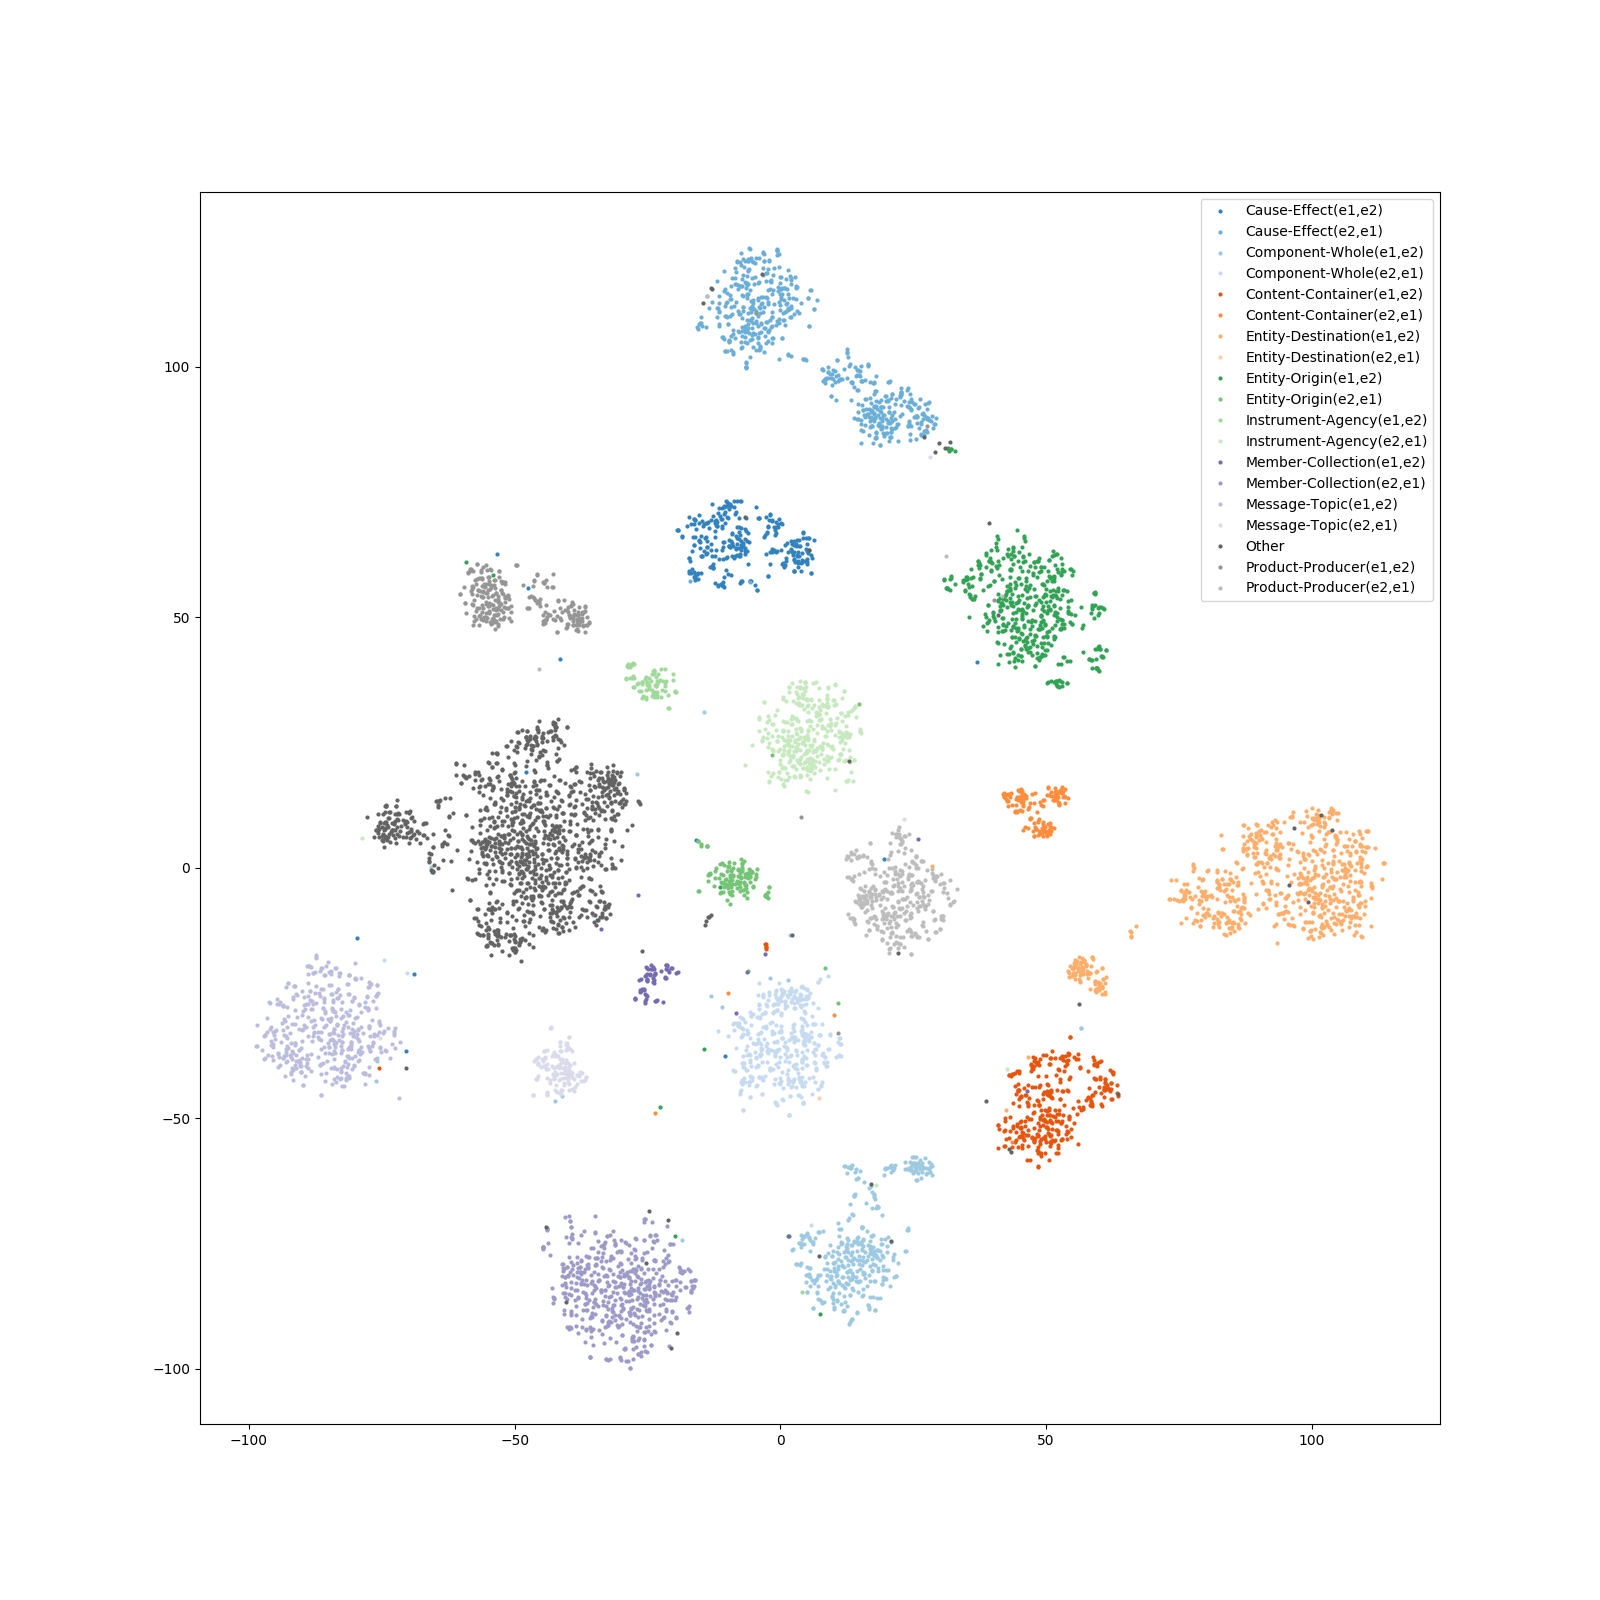

/home/nlp2017/.local/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


<IPython.core.display.Javascript object>


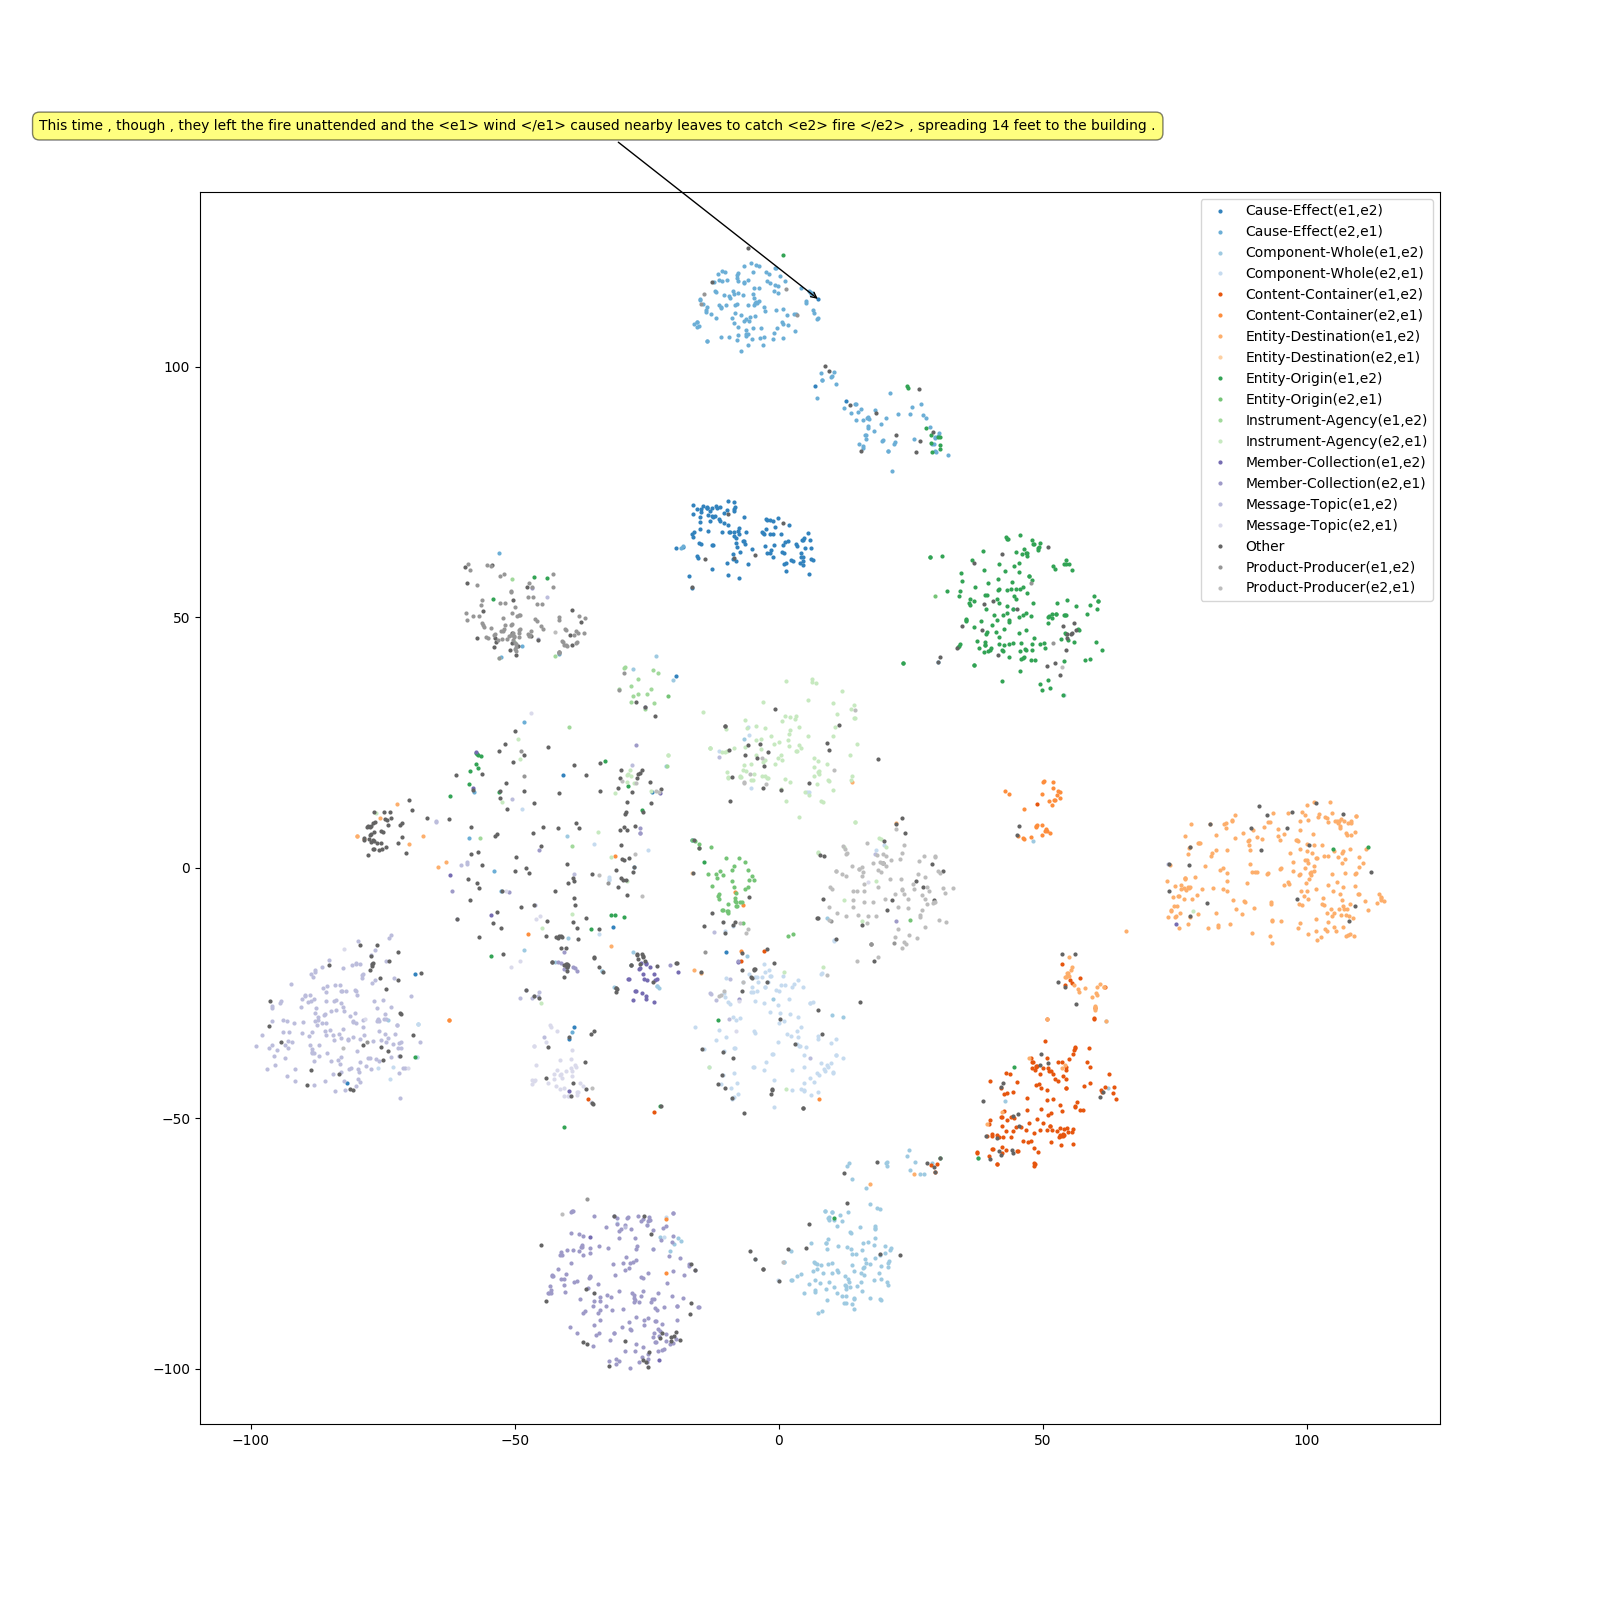

In [20]:
datas = [(train_input, train_output),(test_input, test_output)]
#datas = [(test_input[:100], test_output[:100])]
temp = visualization_in_2D(datas, relation_extr)

<IPython.core.display.Javascript object>


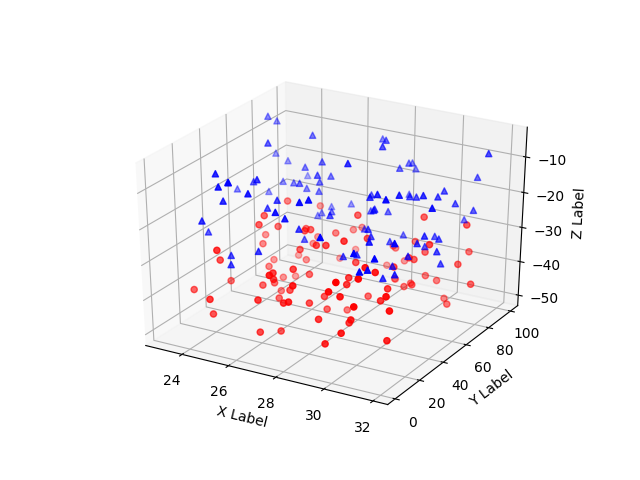

In [21]:
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def randrange(n, vmin, vmax):
    return (vmax-vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zl, zh)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()